In [85]:
import argparse, pydicom
import torch
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk

from pathlib import Path
from typing import Any, Dict, Iterable, Tuple, List
from omegaconf import DictConfig, OmegaConf

import tg43.dicom_helper as dhelp
import tg43.contour_helper as chelp
import tg43.dose_calculation as dosecal
import tg43.utils as utils
import tg43.visualization as vis

import src.dataloader as dataloader

In [86]:
def load_hyperparams(config_path: Path) -> Tuple[DictConfig, Dict]:
    """Load MCO-IPSA hyperparameters from YAML and resolve runtime types."""

    cfg = OmegaConf.load(config_path)
    cfg_dict = OmegaConf.to_container(cfg, resolve=True)  # type: ignore[arg-type]
    return cfg

def resolve_single(path_iterable: Iterable[Path], description: str) -> Path:
    """Return the first path from ``path_iterable`` or raise if empty."""

    candidates = sorted(path_iterable)
    if not candidates:
        raise FileNotFoundError(f"No files found for {description}.")
    return candidates[0]

def load_case_paths(root: Path, case_id: int) -> Dict[str, Path]:
    """Collect CT, RTDOSE, RTPLAN, and RTSTRUCT paths for a case."""

    case_dir = root / f"{case_id}"
    if not case_dir.exists():
        raise FileNotFoundError(f"Case directory not found: {case_dir}")

    return {
        "ct": resolve_single(case_dir.glob("CT*/*"), "CT series"),
        "dose": resolve_single(case_dir.glob("RTDOSE*/*/*.dcm"), "RTDOSE file"),
        "plan": resolve_single(case_dir.glob("RTPLAN*/*/*.dcm"), "RTPLAN file"),
        "struct": resolve_single(case_dir.glob("RTSTRUCT*/*/*.dcm"), "RTSTRUCT file"),
    }

In [87]:
cfg = load_hyperparams(Path("config.yaml"))
cfg

{'hyperparams': {'anisotropy_table': './ESTRO/nucletron_mhdr-v2_F.xlsx', 'radial_table': './ESTRO/nucletron_mhdr-v2_gL.xlsx', 'dose_max_cgy': 6000, 'dwell_time_mode': 'perturb', 'scale': 0.1}, 'models': {'dinov3': 'facebook/dinov3-vitb16-pretrain-lvd1689m'}, 'run': {'data-root': '/mnt/d/PRV/GYN_Geneva_wo_Needles', 'case': 'Case6'}}

In [88]:
data_root = Path(cfg['run']['data-root'])
case_id = Path(cfg['run']['case'])
print(f"Data root: {data_root}")
print(f"Case ID: {case_id}")
paths = load_case_paths(data_root, case_id)
paths

Data root: /mnt/d/PRV/GYN_Geneva_wo_Needles
Case ID: Case6


{'ct': PosixPath('/mnt/d/PRV/GYN_Geneva_wo_Needles/Case6/CT_0_20240112/series_3_1.3.6.1.4.1.2452.6.1088874395.1296847118.3536313259.1264601617'),
 'dose': PosixPath('/mnt/d/PRV/GYN_Geneva_wo_Needles/Case6/RTDOSE_0_20240112/series_1_1.3.6.1.4.1.2452.6.2542691449.1298947939.3638676387.3704138358/ima_unknown_uid_1.3.6.1.4.1.2452.6.1444471091.1123319702.4073412502.1826252067.dcm'),
 'plan': PosixPath('/mnt/d/PRV/GYN_Geneva_wo_Needles/Case6/RTPLAN_0_20240112/series_1_1.3.6.1.4.1.2452.6.1356188019.1134003628.1522809736.1180775174/ima_empty_uid_1.3.6.1.4.1.2452.6.3162210145.1093853173.1113596587.2422958571.dcm'),
 'struct': PosixPath('/mnt/d/PRV/GYN_Geneva_wo_Needles/Case6/RTSTRUCT_0_20240112/series_1_1.3.6.1.4.1.2452.6.3775943779.1152257382.1983088276.1409971453/ima_empty_uid_1.3.6.1.4.1.2452.6.3039571248.1233624635.2885846168.1640366842.dcm')}

In [89]:
ct_image, ct_array, ct_metadata = dhelp.load_ct_volume(paths["ct"])
ct_array.shape

(160, 512, 512)

In [90]:
import importlib
importlib.reload(dhelp)

rt_channels, aux_points = dhelp.load_rtplan_by_channel(paths['plan'], all_points=True)
rt_channels, aux_points

([ChannelInfo(setup_number=0, channel_number=1, channel_id='Channel_1', total_time_s=33.1780900468977, final_cumulative_weight=0.73333310879436, positions_cm=[array([  0.5379861, -13.3453959,  47.7999833]), array([  0.5379861, -13.3453959,  47.7999833]), array([  0.5523497, -13.8179753,  47.6373107]), array([  0.5523497, -13.8179753,  47.6373107]), array([  0.5643543, -14.2816131,  47.4528961]), array([  0.5643543, -14.2816131,  47.4528961]), array([  0.5593393, -14.6576535,  47.1279034]), array([  0.5593393, -14.6576535,  47.1279034])], cumulative_weights=array([0.        , 0.18333328, 0.18333328, 0.36666655, 0.36666655,
         0.54999983, 0.54999983, 0.73333311]), relative_positions=array([ 0.,  0.,  5.,  5., 10., 10., 15., 15.]), strengths_U=array([40688.78106796, 40688.78106796, 40688.78106796, 40688.78106796,
         40688.78106796, 40688.78106796, 40688.78106796, 40688.78106796])),
  ChannelInfo(setup_number=0, channel_number=2, channel_id='Channel_2', total_time_s=33.17809004

In [91]:
aux_points

{'dose_reference_points': [{'number': 1,
   'description': 'Recto-Vaginal point',
   'type': 'UNSPECIFIED',
   'positions_cm': array([  1.2448865, -11.9733513,  47.75     ]),
   'roi_number': None,
   'target_prescription_dose_Gy': 4.086263,
   'target_minimum_dose_Gy': None,
   'target_maximum_dose_Gy': None,
   'under_dose_volume_fraction': None,
   'over_dose_volume_fraction': None},
  {'number': 2,
   'description': 'A1',
   'type': 'UNSPECIFIED',
   'positions_cm': array([ -0.4320248, -14.9519257,  50.2039276]),
   'roi_number': None,
   'target_prescription_dose_Gy': 5.9656,
   'target_minimum_dose_Gy': None,
   'target_maximum_dose_Gy': None,
   'under_dose_volume_fraction': None,
   'over_dose_volume_fraction': None},
  {'number': 3,
   'description': 'A2',
   'type': 'UNSPECIFIED',
   'positions_cm': array([  3.5531246, -14.5969116,  50.017804 ]),
   'roi_number': None,
   'target_prescription_dose_Gy': 5.939868,
   'target_minimum_dose_Gy': None,
   'target_maximum_dose_Gy': 

In [92]:
def get_ref_point(points, label):
    for entry in points.get("dose_reference_points", []):
        if entry["description"].strip().lower() == label.lower():
            return entry
    raise ValueError(f"{label} point not found in RTPLAN.")

art_point = get_ref_point(aux_points, "Art")
alt_point = get_ref_point(aux_points, "Alt")
art_point

{'number': 30,
 'description': 'Art',
 'type': 'UNSPECIFIED',
 'positions_cm': array([ -0.4485057, -14.9549927,  50.209259 ]),
 'roi_number': None,
 'target_prescription_dose_Gy': 5.898567,
 'target_minimum_dose_Gy': None,
 'target_maximum_dose_Gy': None,
 'under_dose_volume_fraction': None,
 'over_dose_volume_fraction': None}

In [93]:
import importlib
importlib.reload(dhelp)

dhelp.extract_dwell_positions(ct_image, rt_channels, unique=True)

{'position': [(262, 252, 84),
  (262, 257, 85),
  (262, 246, 83),
  (262, 241, 81),
  (282, 247, 83),
  (282, 243, 81),
  (281, 259, 84),
  (282, 253, 84),
  (274, 241, 95),
  (273, 245, 90),
  (274, 243, 92),
  (273, 247, 88),
  (278, 227, 111),
  (276, 235, 102),
  (277, 231, 107),
  (277, 229, 109),
  (275, 237, 100),
  (275, 239, 97),
  (276, 233, 104)],
 'channel': [1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]}

In [94]:
def fliter_redundant_positions(positions: np.ndarray) -> np.ndarray:
    """ Filter out redundant positions that are closer than the threshold distance. """
    
    seen = set()
    unique_arrays = []
    for position in positions:
        key = tuple(position.tolist())          # immutable surrogate
        if key in seen:
            continue
        seen.add(key)
        unique_arrays.append(position)
        
    return np.array(unique_arrays)

def reference_points(rt_channels, offset_ovoid=1.5, offset_tandem=2) -> Dict[str, np.ndarray]:
    """ default offsets:
    offset_ovoid = 1 + 0.5  # 1 cm (ovoid thickness) + 0.5 cm (margin from ovoid surface)
    offset_tandem = 2  # 2 cm margin from tandem source position
    """

    pos_ovoid_left = fliter_redundant_positions(rt_channels[0].positions_cm)
    pos_ovoid_right = fliter_redundant_positions(rt_channels[1].positions_cm)
    pos_tandem = fliter_redundant_positions(rt_channels[2].positions_cm)

    pos_a_left = np.array(alt_point["positions_cm"])
    pos_a_right = np.array(art_point["positions_cm"])

    def _unit_vector(vec: np.ndarray) -> np.ndarray:
        norm = np.linalg.norm(vec)
        if norm == 0:
            raise ValueError("Encountered a zero-length vector while normalizing")
        return vec / norm

    ovoid_center = (np.mean(pos_ovoid_right, axis=0) + np.mean(pos_ovoid_left, axis=0)) / 2
    ovoid_axis = np.mean(pos_ovoid_right, axis=0) - np.mean(pos_ovoid_left, axis=0)
    tandem_axis = pos_tandem[-1] - pos_tandem[0]

    ovoid_dir = _unit_vector(ovoid_axis)
    tandem_dir = _unit_vector(tandem_axis)

    dot_val = np.dot(ovoid_dir, tandem_dir)
    angle_deg = np.degrees(np.arccos(np.clip(dot_val, -1.0, 1.0)))
    print(f"Angle between ovoid cluster and tandem axes: {angle_deg:.2f} deg")
    if np.isclose(angle_deg, 90.0, atol=5.0):
        print("Approximately orthogonal within +/- 5 deg tolerance.")
    else:
        print("Not orthogonal within +/- 5 deg tolerance.")
        
    ref_ovoid_left = pos_ovoid_left - (ovoid_dir * offset_ovoid)
    ref_ovoid_right = pos_ovoid_right + (ovoid_dir * offset_ovoid)

    ref_tandem_left = pos_tandem - (ovoid_dir * offset_tandem)
    ref_tandem_right = pos_tandem + (ovoid_dir * offset_tandem)

    threshold_distance = 0.5  # 0.5 cm threshold along tandem direction
    ref_tandem_left = ref_tandem_left[np.linalg.norm(pos_tandem - ovoid_center, axis=1) >= threshold_distance]
    ref_tandem_right = ref_tandem_right[np.linalg.norm(pos_tandem - ovoid_center, axis=1) >= threshold_distance]

    def _filter_by_pointa(ref_tandem, pos_a):

        delta_cm = ref_tandem - pos_a
        tandem_axis = ref_tandem[-1] - ref_tandem[0]
        tandem_axis /= np.linalg.norm(tandem_axis)

        proj_mm = (delta_cm @ tandem_axis) * 10.0
        mask = proj_mm <= 5.0
        return ref_tandem[mask]

    ref_tandem_left = _filter_by_pointa(ref_tandem_left[1:], pos_a_left)
    ref_tandem_right = _filter_by_pointa(ref_tandem_right[1:], pos_a_right)

    return {
        "ref_ovoid_left": ref_ovoid_left[1:3], 
        "ref_ovoid_right": ref_ovoid_right[1:3], 
        "ref_tandem_left": ref_tandem_left,
        "ref_tandem_right": ref_tandem_right,
    }

In [95]:
pos_a_left = np.array(alt_point["positions_cm"])
pos_a_right = np.array(art_point["positions_cm"])

Angle between ovoid cluster and tandem axes: 90.29 deg
Approximately orthogonal within +/- 5 deg tolerance.


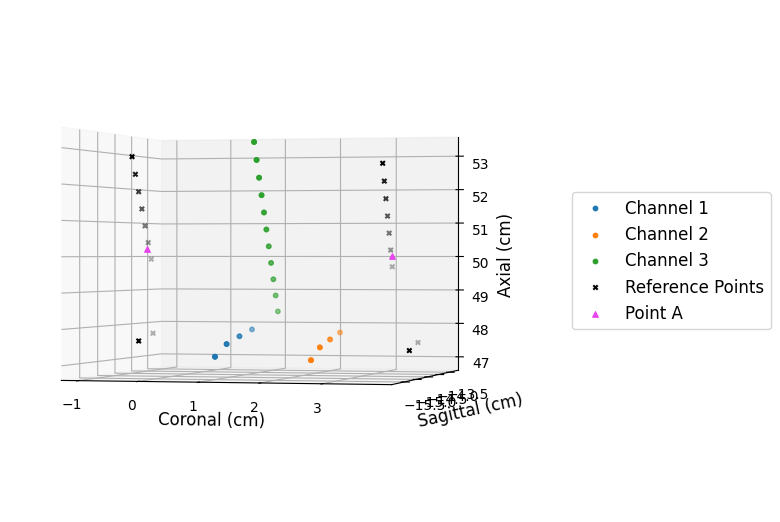

In [96]:
refs = reference_points(rt_channels)
ref_ovoid_left = refs['ref_ovoid_left']
ref_ovoid_right = refs['ref_ovoid_right']
ref_tandem_left = refs['ref_tandem_left']
ref_tandem_right = refs['ref_tandem_right']

fontsize = 12
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

for channel in rt_channels:
    positions = np.array(channel.positions_cm)
    # ax.scatter(Coronal, Sagittal, Axial)
    ax.scatter(positions[:, 0], positions[:, 1], positions[:, 2], s=10, label=f'Channel {channel.channel_number}')
ax.scatter(ref_ovoid_left[:, 0], ref_ovoid_left[:, 1], ref_ovoid_left[:, 2], s=10, marker='x', color='black', label='Reference Points')
ax.scatter(ref_ovoid_right[:, 0], ref_ovoid_right[:, 1], ref_ovoid_right[:, 2], s=10, marker='x', color='black')
ax.scatter(ref_tandem_left[:, 0], ref_tandem_left[:, 1], ref_tandem_left[:, 2], s=10, marker='x', color='black')
ax.scatter(ref_tandem_right[:, 0], ref_tandem_right[:, 1], ref_tandem_right[:, 2], s=10, marker='x', color='black')

ax.scatter(pos_a_left[0], pos_a_left[1], pos_a_left[2], s=15, marker='^', color="#e745ed", label="Point A")
ax.scatter(pos_a_right[0], pos_a_right[1], pos_a_right[2], s=15, marker='^', color="#e745ed")

ax.set_xlabel('Coronal (cm)', fontsize=fontsize)
ax.set_ylabel('Sagittal (cm)', fontsize=fontsize)
ax.set_zlabel('Axial (cm)', fontsize=fontsize)

ax.view_init(elev=0, azim=-75, roll=0)
plt.legend(bbox_to_anchor=(1.1, 0.5), loc='center left', fontsize=fontsize)
plt.tight_layout()
plt.show()

In [97]:
tables = dosecal.load_nucletron_tg43_tables(
    cfg["hyperparams"]["anisotropy_table"],
    cfg["hyperparams"]["radial_table"],
)
dwells, _ = dosecal.dwells_from_records(rt_channels)
channel_map = dataloader.map_channel_dwell_indices(rt_channels, dwells)
tandem_dwells = [dwells[i] for i in channel_map[2]]  # channel index 2 == tandem

ref_point = refs["ref_tandem_left"][0]  # or whichever tandem reference (cm coords)
dose_per_second = dosecal.compute_tg43_dose_at_points(
    tandem_dwells,
    np.asarray(ref_point),
    tables,
    dwell_time_override_s=1.0,      # 1 s per dwell -> Gy per second
)[0]

target_dose = 6.0  # Gy
required_time_s = target_dose / dose_per_second
print(f"Run each tandem dwell for {required_time_s:.2f} s to reach 6 Gy.")


Run each tandem dwell for 0.16 s to reach 6 Gy.


In [98]:
prescription_dose_gy = 6.0  # Gy
group_names = ['tandem', 'ovoid_left', 'ovoid_right']
group_dwells = {
    'ovoid_left': [dwells[i] for i in channel_map[0]],
    'ovoid_right': [dwells[i] for i in channel_map[1]],
    'tandem': [dwells[i] for i in channel_map[2]],
}
target_multipliers = {
    'tandem': 1.0,
    'ovoid_left': 1.4,
    'ovoid_right': 1.4,
}
constraint_points = [
    ('tandem', ref_tandem_left[0]),
    ('tandem', ref_tandem_right[0]),
    ('ovoid_left', ref_ovoid_left[0]),
    ('ovoid_right', ref_ovoid_right[0]),
]
A_rows = []
b = []
for group, point in constraint_points:
    row = np.zeros(len(group_names), dtype=float)
    rate = dosecal.compute_tg43_dose_at_points(
        group_dwells[group],
        np.asarray(point),
        tables,
        dwell_time_override_s=1.0,
    )[0]
    row[group_names.index(group)] = rate
    A_rows.append(row)
    b.append(target_multipliers[group] * prescription_dose_gy)
A = np.vstack(A_rows)
b = np.asarray(b, dtype=float)
scale_factors, *_ = np.linalg.lstsq(A, b, rcond=None)
scale_map = dict(zip(group_names, scale_factors))
print('Scale factors:')
for name, value in scale_map.items():
    print(f'  {name}: {value:.3f}x')
for idx in channel_map[2]:
    dwells[idx].dwell_time_s *= scale_map['tandem']
for idx in channel_map[0]:
    dwells[idx].dwell_time_s *= scale_map['ovoid_left']
for idx in channel_map[1]:
    dwells[idx].dwell_time_s *= scale_map['ovoid_right']
print('Dose at constraint points after scaling:')
for group, point in constraint_points:
    dose_val = dosecal.compute_tg43_dose_at_points(
        group_dwells[group],
        np.asarray(point),
        tables,
    )[0]
    goal = target_multipliers[group] * prescription_dose_gy
    print(f'  {group} @ {goal:.1f} Gy target -> {dose_val:.2f} Gy')
scaled_channels = dosecal.rebuild_channels(rt_channels, dwells)


Scale factors:
  tandem: 0.159x
  ovoid_left: 0.215x
  ovoid_right: 0.215x
Dose at constraint points after scaling:
  tandem @ 6.0 Gy target -> 74.06 Gy
  tandem @ 6.0 Gy target -> 73.78 Gy
  ovoid_left @ 8.4 Gy target -> 34.85 Gy
  ovoid_right @ 8.4 Gy target -> 34.87 Gy


In [99]:
dose_result = dosecal.calculate_and_resample_to_ct(
    ct_image=ct_image,
    channels=scaled_channels,
    anisotropy_path=cfg['hyperparams']['anisotropy_table'],
    radial_path=cfg['hyperparams']['radial_table'],
)
scaled_dose_image = dose_result.resampled_image
scaled_dose_array = dose_result.resampled_array
dose_result.metadata


{'num_channels': 3.0,
 'num_dwells': 38.0,
 'total_dwell_time_s': 55.37554066970678,
 'relative_time_channels': 0.0,
 'total_dwell_weight_U_s': 2253163.250829753,
 'grid_spacing_mm': 2.5,
 'resampled_shape': (160, 512, 512)}

In [113]:
scaled_dose_array.min(), scaled_dose_array.max()

(np.float32(0.0), np.float32(114830.664))

In [117]:
# Rotate CT/Dose volumes so the applicator aligns with axial/coronal/sagittal axes
def build_applicator_frame(rt_channels):
    pos_left = np.vstack([p for p in rt_channels[0].positions_cm if p is not None])
    pos_right = np.vstack([p for p in rt_channels[1].positions_cm if p is not None])
    pos_tandem = np.vstack([p for p in rt_channels[2].positions_cm if p is not None])
    left_center = pos_left.mean(axis=0)
    right_center = pos_right.mean(axis=0)
    tandem_axis = pos_tandem[-1] - pos_tandem[0]
    lateral_axis = right_center - left_center
    tandem_dir = tandem_axis / np.linalg.norm(tandem_axis)
    lateral_axis -= tandem_dir * np.dot(lateral_axis, tandem_dir)
    lateral_dir = lateral_axis / np.linalg.norm(lateral_axis)
    anterior_dir = np.cross(tandem_dir, lateral_dir)
    anterior_dir /= np.linalg.norm(anterior_dir)
    rotation = np.vstack([lateral_dir, anterior_dir, tandem_dir])
    center = (pos_tandem[0] + pos_tandem[-1]) / 2
    return rotation, center

def rotate_volume(image, rotation, center_cm, *, interpolator=sitk.sitkNearestNeighbor, default_value=0):
    transform = sitk.AffineTransform(3)
    transform.SetMatrix(rotation.flatten())                  # rotation rows are new axes
    transform.SetCenter(tuple((center_cm * 10.0).tolist()))  # cm → mm

    resampled = sitk.Resample(
        image,
        image,                      # use same grid as reference
        transform.GetInverse(),     # map output coords → input coords
        interpolator,
        default_value,
        image.GetPixelID(),
    )
    return resampled

def rotate_points(points_cm, rotation, center_cm):
    pts = np.asarray(points_cm, dtype=float)
    rel = pts - center_cm[np.newaxis, :]
    rotated = (rotation @ rel.T).T + center_cm  # shape (N, 3)
    return rotated

rotation_matrix, rotation_center = build_applicator_frame(rt_channels)
rotated_ct_image = rotate_volume(ct_image, rotation_matrix, rotation_center)
rotated_ct_array = sitk.GetArrayFromImage(rotated_ct_image)
rotated_dose_image = rotate_volume(dose_result.resampled_image, rotation_matrix, rotation_center)
rotated_dose_array = sitk.GetArrayFromImage(rotated_dose_image)

In [119]:
rotated_dose_array.min(), rotated_dose_array.max()

(np.float32(0.0), np.float32(114830.664))

In [103]:
def physical_to_voxel(image, points_cm):
    points_mm = np.asarray(points_cm, dtype=float) * 10.0

    origin_mm = np.array(image.GetOrigin(), dtype=float)
    spacing_mm = np.array(image.GetSpacing(), dtype=float)
    direction = np.array(image.GetDirection(), dtype=float).reshape(3, 3)

    # Convert patient-space mm → continuous voxel indices
    rel = points_mm - origin_mm
    direction_inv = np.linalg.inv(direction)
    indices = (direction_inv @ rel.T).T / spacing_mm

    return indices

rotated_dwells = []
for channel in rt_channels:
    pts_cm = [p for p in channel.positions_cm if p is not None]
    if not pts_cm:
        continue
    rotated = rotate_points(pts_cm, rotation_matrix, rotation_center)
    rotated_dwells.append(physical_to_voxel(rotated_ct_image, rotated))

rotated_ref_ovoid_left = physical_to_voxel(rotated_ct_image, rotate_points(refs['ref_ovoid_left'], rotation_matrix, rotation_center))
rotated_ref_ovoid_right = physical_to_voxel(rotated_ct_image, rotate_points(refs['ref_ovoid_right'], rotation_matrix, rotation_center))
rotated_ref_tandem_left = physical_to_voxel(rotated_ct_image, rotate_points(refs['ref_tandem_left'], rotation_matrix, rotation_center))
rotated_ref_tandem_right = physical_to_voxel(rotated_ct_image, rotate_points(refs['ref_tandem_right'], rotation_matrix, rotation_center))

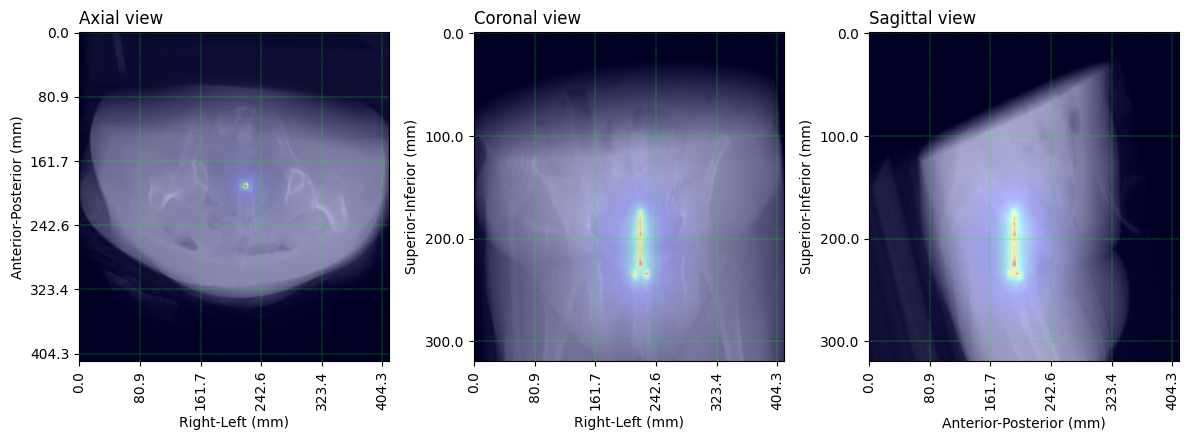

In [104]:
ct_view = rotated_ct_array
dose_overlay = utils.dose_clip(rotated_dose_array, 0, 3000)
# np.save(save_dir / f"{save_name}.npy", dose_overlay)

x_ticks = range(ct_metadata["size"][0])
y_ticks = range(ct_metadata["size"][1])
z_ticks = range(ct_metadata["size"][2])

x_coords_mm = np.array(x_ticks) * ct_metadata["spacing"][0]
y_coords_mm = np.array(y_ticks) * ct_metadata["spacing"][1]
z_coords_mm = np.array(z_ticks) * ct_metadata["spacing"][2]

tick_step = 100
z_tick_step = max(1, tick_step // 2)
alpha = 0.3

plt.figure(figsize=(12, 4.5), dpi=100)

plt.subplot(1, 3, 1)
plt.title("Axial view", loc="left")
plt.imshow(np.sum(ct_view, axis=0), aspect="auto", cmap="gray")
plt.imshow(np.sum(dose_overlay, axis=0), aspect="auto", cmap="jet", alpha=alpha)
plt.xticks(ticks=x_ticks[::tick_step], labels=np.round(x_coords_mm[::tick_step], 1), rotation=90)
plt.yticks(ticks=y_ticks[::tick_step], labels=np.round(y_coords_mm[::tick_step], 1))
plt.xlabel("Right-Left (mm)")
plt.ylabel("Anterior-Posterior (mm)")
plt.grid(linewidth=0.3, color="lime", linestyle="--")

plt.subplot(1, 3, 2)
plt.title("Coronal view", loc="left")
plt.imshow(np.sum(ct_view, axis=1), aspect="auto", cmap="gray")
plt.imshow(np.sum(dose_overlay, axis=1), aspect="auto", cmap="jet", alpha=alpha)
plt.xticks(ticks=x_ticks[::tick_step], labels=np.round(x_coords_mm[::tick_step], 1), rotation=90)
plt.yticks(ticks=z_ticks[::z_tick_step], labels=np.round(z_coords_mm[::z_tick_step], 1))
plt.xlabel("Right-Left (mm)")
plt.ylabel("Superior-Inferior (mm)")
plt.grid(linewidth=0.3, color="lime", linestyle="--")

plt.subplot(1, 3, 3)
plt.title("Sagittal view", loc="left")
plt.imshow(np.sum(ct_view, axis=2), aspect="auto", cmap="gray")
plt.imshow(np.sum(dose_overlay, axis=2), aspect="auto", cmap="jet", alpha=alpha)
plt.xticks(ticks=y_ticks[::tick_step], labels=np.round(y_coords_mm[::tick_step], 1), rotation=90)
plt.yticks(ticks=z_ticks[::z_tick_step], labels=np.round(z_coords_mm[::z_tick_step], 1))
plt.xlabel("Anterior-Posterior (mm)")
plt.ylabel("Superior-Inferior (mm)")
plt.grid(linewidth=0.3, color="lime", linestyle="--")

plt.tight_layout()
plt.show()

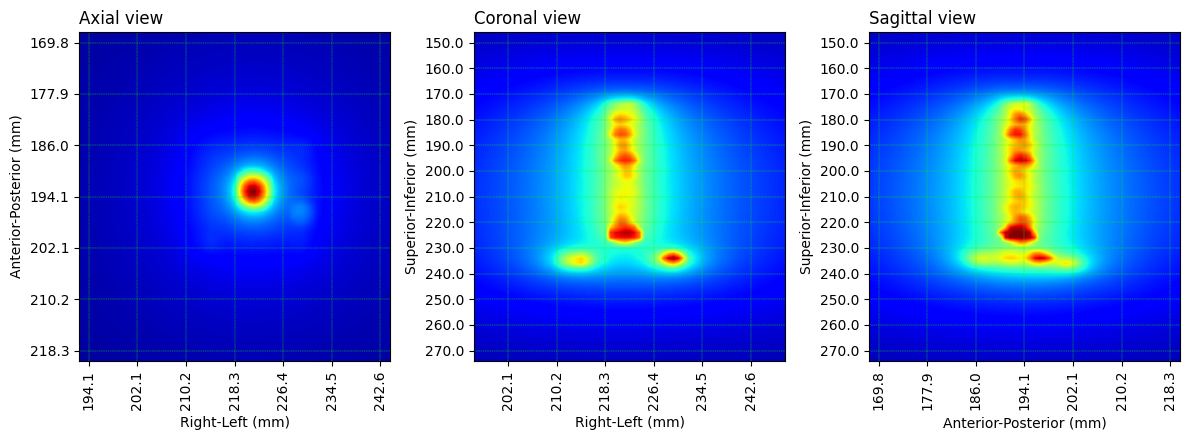

In [105]:
ct_view = rotated_ct_array
dose_overlay = utils.dose_clip(rotated_dose_array, 0, 3000)
# np.save(save_dir / f"{save_name}.npy", dose_overlay)

x_ticks = range(ct_metadata["size"][0])
y_ticks = range(ct_metadata["size"][1])
z_ticks = range(ct_metadata["size"][2])

x_coords_mm = np.array(x_ticks) * ct_metadata["spacing"][0]
y_coords_mm = np.array(y_ticks) * ct_metadata["spacing"][1]
z_coords_mm = np.array(z_ticks) * ct_metadata["spacing"][2]

tick_step = 10
z_tick_step = max(1, tick_step // 2)
alpha = 1.0

plt.figure(figsize=(12, 4.5), dpi=100)

plt.subplot(1, 3, 1)
plt.title("Axial view", loc="left")
plt.imshow(np.sum(ct_view, axis=0), aspect="auto", cmap="gray")
plt.imshow(np.sum(dose_overlay, axis=0), interpolation='bilinear', aspect="auto", cmap="jet", alpha=alpha)
plt.xticks(ticks=x_ticks[::tick_step], labels=np.round(x_coords_mm[::tick_step], 1), rotation=90)
plt.yticks(ticks=y_ticks[::tick_step], labels=np.round(y_coords_mm[::tick_step], 1))
x_center = 270
y_center = 240
size_zoom = 64
plt.xlim(x_center-size_zoom//2, x_center+size_zoom//2)
plt.ylim(y_center+size_zoom//2, y_center-size_zoom//2)
plt.xlabel("Right-Left (mm)")
plt.ylabel("Anterior-Posterior (mm)")
plt.grid(linewidth=0.3, color="lime", linestyle="--")

plt.subplot(1, 3, 2)
plt.title("Coronal view", loc="left")
plt.imshow(np.sum(ct_view, axis=1), aspect="auto", cmap="gray")
plt.imshow(np.sum(dose_overlay, axis=1), interpolation='bilinear', aspect="auto", cmap="jet", alpha=alpha)
plt.xticks(ticks=x_ticks[::tick_step], labels=np.round(x_coords_mm[::tick_step], 1), rotation=90)
plt.yticks(ticks=z_ticks[::z_tick_step], labels=np.round(z_coords_mm[::z_tick_step], 1))
x_center = 275
y_center = 105
size_zoom = 64
plt.xlim(x_center-size_zoom//2, x_center+size_zoom//2)
plt.ylim(y_center+size_zoom//2, y_center-size_zoom//2)
plt.xlabel("Right-Left (mm)")
plt.ylabel("Superior-Inferior (mm)")
plt.grid(linewidth=0.3, color="lime", linestyle="--")

plt.subplot(1, 3, 3)
plt.title("Sagittal view", loc="left")
plt.imshow(np.sum(ct_view, axis=2), aspect="auto", cmap="gray")
plt.imshow(np.sum(dose_overlay, axis=2), interpolation='bilinear', aspect="auto", cmap="jet", alpha=alpha)
plt.xticks(ticks=y_ticks[::tick_step], labels=np.round(y_coords_mm[::tick_step], 1), rotation=90)
plt.yticks(ticks=z_ticks[::z_tick_step], labels=np.round(z_coords_mm[::z_tick_step], 1))
x_center = 240
y_center = 105
size_zoom = 64
plt.xlim(x_center-size_zoom//2, x_center+size_zoom//2)
plt.ylim(y_center+size_zoom//2, y_center-size_zoom//2)
plt.xlabel("Anterior-Posterior (mm)")
plt.ylabel("Superior-Inferior (mm)")
plt.grid(linewidth=0.3, color="lime", linestyle="--")

plt.tight_layout()
plt.show()

6.0 [3000. 6000. 8400.]


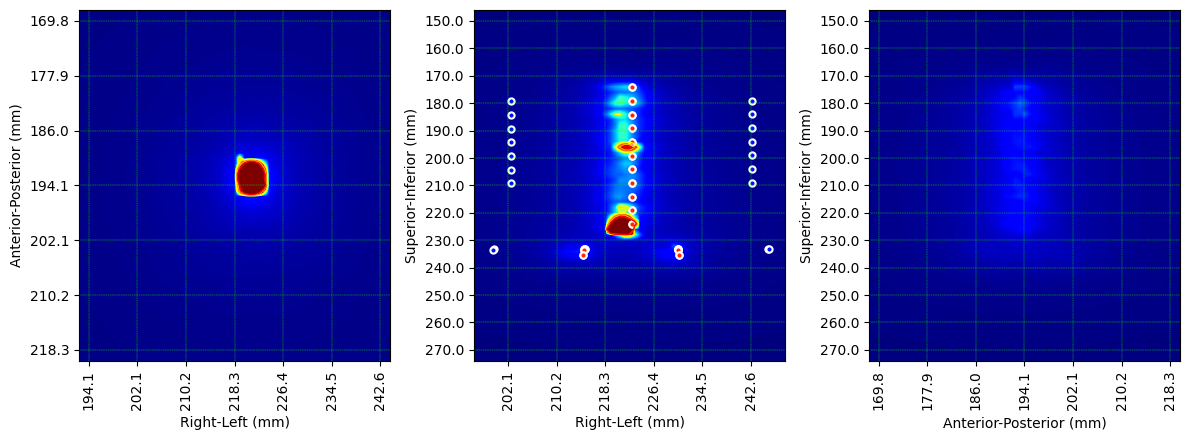

In [127]:
dose_overlay = utils.dose_clip(rotated_dose_array, 0, prescription_dose_gy*1000)
vmin, vmax = np.min(dose_overlay), np.max(dose_overlay)
iso_levels = np.array([0.5, 1.0, 1.4]) * prescription_dose_gy*1000  # cGy
print(prescription_dose_gy, iso_levels)

fontsize=12

view_axial = rotated_dose_array[112, :, :]
view_coronal = rotated_dose_array[:, 240, :]
view_sagittal = rotated_dose_array[:, :, 270]

plt.figure(figsize=(12, 4.5), dpi=100)

plt.subplot(1, 3, 1)
plt.imshow(view_axial, interpolation='bilinear', aspect="auto", cmap="jet", vmin=vmin, vmax=vmax)
cs = plt.contour(view_axial, levels=iso_levels, colors=["yellow","orange","red"], linewidths=1.0)
plt.clabel(cs, fmt="%.1f cGy", fontsize=fontsize)
plt.xticks(ticks=x_ticks[::tick_step], labels=np.round(x_coords_mm[::tick_step], 1), rotation=90)
plt.yticks(ticks=y_ticks[::tick_step], labels=np.round(y_coords_mm[::tick_step], 1))
x_center = 270
y_center = 240
size_zoom = 64
plt.xlim(x_center-size_zoom//2, x_center+size_zoom//2)
plt.ylim(y_center+size_zoom//2, y_center-size_zoom//2)
plt.xlabel("Right-Left (mm)")
plt.ylabel("Anterior-Posterior (mm)")
plt.grid(linewidth=0.3, color="lime", linestyle="--")

plt.subplot(1, 3, 2)
plt.imshow(view_coronal, interpolation='bilinear', aspect="auto", cmap="jet", vmin=vmin, vmax=vmax)
cs2 = plt.contour(view_coronal, levels=iso_levels, colors=["yellow","orange","red"], linewidths=1.0)
plt.clabel(cs2, fmt="%1.1f", inline=True, fontsize=fontsize)
plt.scatter(rotated_dwells[0][:, 0], rotated_dwells[0][:, 2], s=20, marker='o', edgecolors="#ffffff", linewidths=1.5, color="#ff2600")
plt.scatter(rotated_dwells[1][:, 0], rotated_dwells[1][:, 2], s=20, marker='o', edgecolors='#ffffff', linewidths=1.5, color='#ff2600')
plt.scatter(rotated_dwells[2][:, 0], rotated_dwells[2][:, 2], s=20, marker='o', edgecolors='#ffffff', linewidths=1.5, color='#ff2600')
plt.scatter(rotated_ref_ovoid_left[:, 0], rotated_ref_ovoid_left[:, 2], s=20, marker='o', edgecolors='#ffffff', linewidths=1.5, color="#0011ff")
plt.scatter(rotated_ref_ovoid_right[:, 0], rotated_ref_ovoid_right[:, 2], s=20, marker='o', edgecolors='#ffffff', linewidths=1.5, color="#0011ff")
plt.scatter(rotated_ref_tandem_left[:, 0], rotated_ref_tandem_left[:, 2], s=20, marker='o', edgecolors='#ffffff', linewidths=1.5, color="#0011ff")
plt.scatter(rotated_ref_tandem_right[:, 0], rotated_ref_tandem_right[:, 2], s=20, marker='o', edgecolors='#ffffff', linewidths=1.5, color="#0011ff")


plt.xticks(ticks=x_ticks[::tick_step], labels=np.round(x_coords_mm[::tick_step], 1), rotation=90)
plt.yticks(ticks=z_ticks[::z_tick_step], labels=np.round(z_coords_mm[::z_tick_step], 1))
x_center = 275
y_center = 105
size_zoom = 64
plt.xlim(x_center-size_zoom//2, x_center+size_zoom//2)
plt.ylim(y_center+size_zoom//2, y_center-size_zoom//2)
plt.xlabel("Right-Left (mm)")
plt.ylabel("Superior-Inferior (mm)")
plt.grid(linewidth=0.3, color="lime", linestyle="--")

plt.subplot(1, 3, 3)
plt.imshow(view_sagittal, interpolation='bilinear', aspect="auto", cmap="jet", vmin=vmin, vmax=vmax)
cs = plt.contour(view_sagittal, levels=iso_levels, colors=["yellow","orange","red"], linewidths=1.0)
plt.clabel(cs, fmt="%.1f cGy", fontsize=fontsize)
plt.xticks(ticks=y_ticks[::tick_step], labels=np.round(y_coords_mm[::tick_step], 1), rotation=90)
plt.yticks(ticks=z_ticks[::z_tick_step], labels=np.round(z_coords_mm[::z_tick_step], 1))
x_center = 240
y_center = 105
size_zoom = 64
plt.xlim(x_center-size_zoom//2, x_center+size_zoom//2)
plt.ylim(y_center+size_zoom//2, y_center-size_zoom//2)
plt.xlabel("Anterior-Posterior (mm)")
plt.ylabel("Superior-Inferior (mm)")
plt.grid(linewidth=0.3, color="lime", linestyle="--")

plt.tight_layout()
plt.show()